# NFL: Predict the next play

Using 8 years (2009-2016) play-by-play data, I am hoping to build a model to predict what action a team will take on the upcoming play (run, pass, kick, etc.).

## Data acquisition

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')
                    

import matplotlib.pyplot as plt  # to plot
import pandas as pd  # to handle data
import statsmodels.api as sm  # to explore model
import itertools
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score  # metrics
from sklearn.linear_model import LogisticRegression  # model
from sklearn.tree import DecisionTreeClassifier  # model
from sklearn.ensemble import RandomForestClassifier  # model
from sklearn.cross_validation import cross_val_score # model
from sklearn.neighbors import KNeighborsClassifier  # model
import pylab as pl
import numpy as np  # functions to work with numerical data
import seaborn as sns  # pretty plots
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import svm, datasets

df = pd.read_csv("alldata.csv")

"""
Dropping some irrelevant columns. These columns describe post play information, and thus 
aren't useful to make predictions. (Though they will be used when I implement time series analysis!)
I did a lot of pre-data editing in SQL as well.
"""
remove_cols = ['Onsidekick','desc','PuntResult','PassOutcome','RecFumbTeam','RunGap','RunLocation',
               'PassLength','PassLocation', 'ydsnet','FirstDown','Yards.Gained','AirYards',
               'YardsAfterCatch','QBHit','InterceptionThrown', 'Fumble','Sack','PassAttempt',
               'RushAttempt','Challenge.Replay','Accepted.Penalty','Penalty.Yards', 'Reception',
               'HomeTimeouts_Remaining_Post', 'AwayTimeouts_Remaining_Post','No_Score_Prob',
               'Opp_Field_Goal_Prob', 'Opp_Safety_Prob', 'Opp_Touchdown_Prob', 'Field_Goal_Prob', 
               'Safety_Prob', 'Touchdown_Prob', 'ExPoint_Prob', 'TwoPoint_Prob', 'ExpPts', 'EPA', 
               'airEPA', 'yacEPA', 'Home_WP_pre','Away_WP_pre', 'Home_WP_post', 'Away_WP_post', 
               'Win_Prob', 'WPA', 'Season', 'Drive','qtr','time','TimeUnder', 'yrdline100', 
               'PlayAttempted', 'sp', 'Touchdown', 'ExPointResult', 'TwoPointConv', 'DefTwoPoint', 
               'Safety', 'Passer', 'Passer_ID', 'Interceptor', 'Rusher', 'Rusher_ID', 'Receiver',
             'Receiver_ID', 'ReturnResult', 'Returner', 'BlockingPlayer', 'Tackler1', 'Tackler2', 
               'FieldGoalResult','FieldGoalDistance', 'RecFumbPlayer', 'ChalReplayResult', 'PenalizedTeam', 
               'PenaltyType', 'PenalizedPlayer','Timeout_Indicator', 'Timeout_Team']
 
for col in remove_cols:
    df = df.drop([col], axis =1)
    
print df.head()

/Users/davidfeld/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


       GameID  down  TimeSecs  PlayTimeDiff  SideofField  yrdln  ydstogo  \
0  2009091000   1.0    3496.0          11.0          1.0    2.0       10   
1  2009091304   2.0    1755.0          35.0          0.0   50.0        5   
2  2010091301   1.0     926.0          42.0          0.0   50.0       10   
3  2010091902   3.0    1860.0          20.0          0.0   50.0        7   
4  2010091902   4.0    1854.0           6.0          0.0   50.0        7   

   GoalToGo  posteam  DefensiveTeam PlayType  PosTeamScore  DefTeamScore  \
0       0.0      1.0            0.0      Run           0.0           0.0   
1       0.0      1.0            0.0      Run          10.0          12.0   
2       0.0      0.0            1.0     Pass          20.0          14.0   
3       0.0      0.0            1.0     Pass           0.0           7.0   
4       0.0      0.0            1.0     Punt           0.0           7.0   

   ScoreDiff  AbsScoreDiff HomeTeam AwayTeam  posteam_timeouts_pre  \
0        0.0    

## Data Cleaning

Let's check out our data.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286221 entries, 0 to 286220
Data columns (total 20 columns):
GameID                        286221 non-null int64
down                          285664 non-null float64
TimeSecs                      286200 non-null float64
PlayTimeDiff                  286190 non-null float64
SideofField                   286217 non-null float64
yrdln                         286217 non-null float64
ydstogo                       286221 non-null int64
GoalToGo                      286217 non-null float64
posteam                       286195 non-null float64
DefensiveTeam                 286195 non-null float64
PlayType                      286221 non-null object
PosTeamScore                  286195 non-null float64
DefTeamScore                  286195 non-null float64
ScoreDiff                     286195 non-null float64
AbsScoreDiff                  286195 non-null float64
HomeTeam                      286221 non-null object
AwayTeam                      2

A lot of these 'float' values should be 'int'. We'll take care of that soon. First let's check for missing values.

In [3]:
# Show where NaN values are and how many
df.isnull().sum()

GameID                          0
down                          557
TimeSecs                       21
PlayTimeDiff                   31
SideofField                     4
yrdln                           4
ydstogo                         0
GoalToGo                        4
posteam                        26
DefensiveTeam                  26
PlayType                        0
PosTeamScore                   26
DefTeamScore                   26
ScoreDiff                      26
AbsScoreDiff                   26
HomeTeam                        0
AwayTeam                        0
posteam_timeouts_pre            0
HomeTimeouts_Remaining_Pre      0
AwayTimeouts_Remaining_Pre      0
dtype: int64

Ok, so the only column with significant missing values is "down" (although 557 out of over 200k is barely significant). I looked into these in SQL and they're basically all for kickoffs, which we're not interested in. So we can safely just drop these rows.

In [4]:
df = df.dropna()

Now that we don't have missing values, let's convert the floats into ints.

In [5]:
for col in list(df):
    if df[col].dtypes == 'float64': df[col] = df[col].astype(int)

Cool, we have the data nice and clean. Let's look at histograms to make sure things are looking as we would expect.

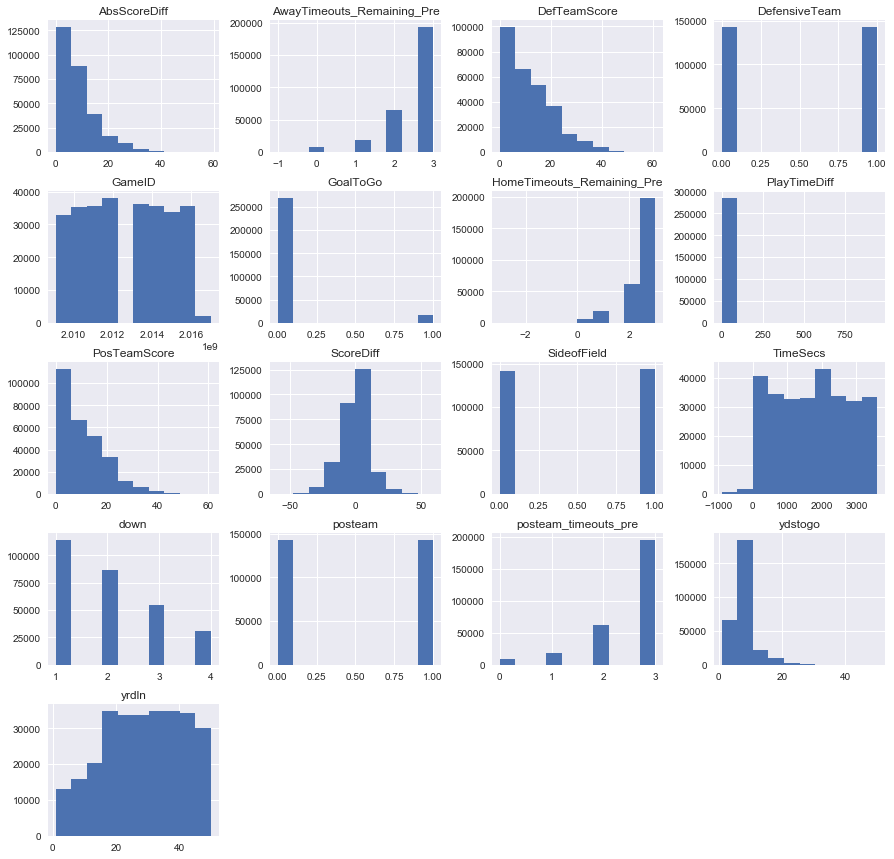

In [6]:
df.hist()
pl.gcf().set_size_inches(15,15)
pl.show()

Everything looks in order. Let's check how correlated our features are.

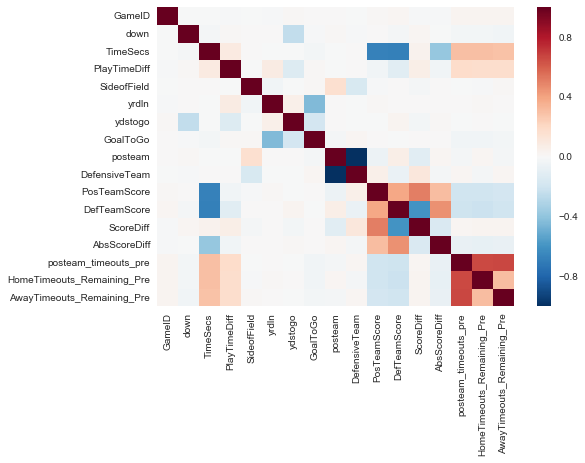

In [7]:
sns.heatmap(df.corr())

Let's also look at our target variable 'PlayType'.

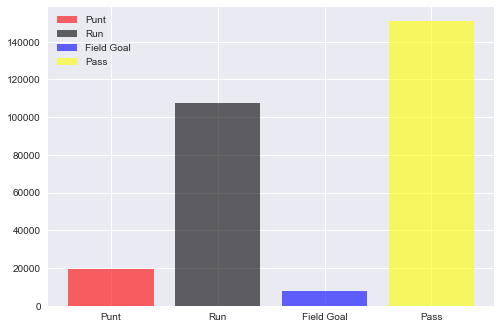

[19557, 107265, 7901, 150931]


In [8]:
def playdistplt(df):
    y = list(df['PlayType'])
    yset = list(set(y))
    counts = []
    for i in yset:
        counts.append(y.count(i))
    colors = ['r','k','b','yellow','g', 'magenta','orange']
    fig, ax = plt.subplots()
    width = 0.4

    dic = {i:(yset[i],colors[i]) for i in range(len(yset))}
    ax1 = plt.subplot(111)
    xval = range(len(yset))

    for j in range(len(xval)):
        ax1.bar(xval[j], counts[j], width=0.8, bottom=0.0, align='center', color=dic[xval[j]][1], alpha=0.6, label=dic[xval[j]][0])
    ax1.set_xticks(xval)
    ax1.set_xticklabels([dic[i][0] for i in xval])
    #ax1.set_facecolor('forestgreen')
    ax1.legend()
    plt.show()
    #fig.savefig('playdist.png',figsize=(14, 14))
    print counts
    
playdistplt(df)

So we have pretty imbalanced data! We'll deal with this by under/oversampling.

### Quick sanity check

Let's do a quick sanity check on our data by looking at the 4th down plays. They should be mostly kicks.

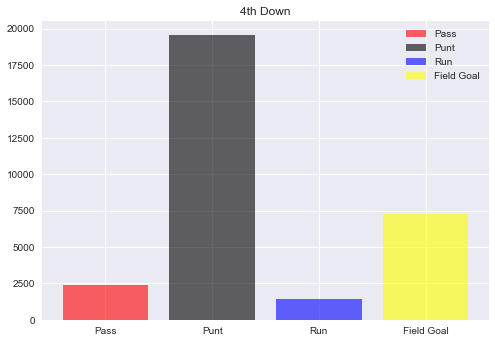

In [9]:
def playdist4dplt(df):
    t1 = df[df['down'] == 4].PlayType
    t1 = list(t1)
    t1set = list(set(t1))
    counts = []
    for i in t1set:
        counts.append(t1.count(i))
    colors = ['r','k','b','yellow','g', 'magenta','orange']
    fig, ax = plt.subplots()
    width = 0.4
    dic = {i:(t1set[i],colors[i]) for i in range(len(t1set))}
    ax1 = plt.subplot(111)
    xval = range(len(t1set))

    for j in range(len(xval)):
        ax1.bar(xval[j], counts[j], width=0.8, bottom=0.0, align='center', color=dic[xval[j]][1], alpha=0.6, label=dic[xval[j]][0])
    ax1.set_xticks(xval)
    ax1.set_xticklabels([dic[i][0] for i in xval])
    ax1.legend()
    plt.title('4th Down')
    plt.show()
    #fig.savefig('playdist4d.png',figsize=(14, 14))
playdist4dplt(df)

Indeed we get a majority of the kicking plays. Our data is making more and more sense!

## Model Building

Here I'm going to define some useful functions. The purpose of each function is described in the comments below.

In [11]:
### Function to make dummy columns. Need dummies for categorical features to feed into classifiers.
def make_dummies(X,column,df):
    dummy = pd.get_dummies(df[column],prefix = column)
    X = X.join(dummy.astype(int), lsuffix= 'P')
    X = X.drop([column], axis =1)
    return X

### Function to engineer features.
def addfeatures(df):
    # Add 'SOFpos4d' feature
    df['SOFpos4d'] = 0
    df['SOFpos4d'][ (df['SideofField'] == df['posteam']) & (df['down'] == 4) ] =1
    df['SOFpos4d'][ (df['SideofField'] != df['posteam']) & (df['down'] == 4) ] =2
    return df
    
### Make df with just predictor columns. PlayType is the target column.
def makefeatures(df):
    X = df.drop(['PlayType'], axis =1)

    ## Columns where you need to make dummies
    dummy_columns = ['down','HomeTeam','AwayTeam']
    # Make dummies
    for column in dummy_columns:
        X = make_dummies(X,column,df)
    return X

# Make target classification array
def maketarget(df):
    y = df['PlayType']
    dic = {'Run':'Run','Pass':'Pass','Field Goal': 'FG', 'Punt': 'Punt'}
    ### Essentially just doing this to abbreviate Field Goal as FG.
    y = y.map(dic)
    return y

# Make an oversampled dataframe
def make_oversample(df,classes):
    #Find which class has most values
    maxim, max_class = 0, ''
    for label in classes:
        if len(df.loc[df['PlayType' ]== label]) > maxim:
            maxim = len(df.loc[df['PlayType' ]== label])
            max_class = label
    
    df_os = df.loc[df['PlayType' ]== max_class]
    classes.remove(max_class)
    
    #Duplicate other classes until there is as many as the max column
    for label in classes:
        df_temp = df.loc[df['PlayType' ]== label]
        while len(df_temp) < maxim:
            df_temp = df_temp.append([df_temp],ignore_index=True)
        df_temp = df_temp.iloc[:maxim]
        df_os = df_os.append([df_temp],ignore_index=True)
    
    #Put dataframe in random order
    df_os = df_os.sample(frac=1)

    return df_os

#Make a Random Forest
def makeRF(X,y):
    #Split dataset into train and test dataset
    train_percentage = 0.7
    train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                            train_size=train_percentage)


    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(train_x, train_y)
    return clf, test_x, test_y

#Make a Random Forest for oversampled dataframe. This needs a seperate function because I am oversampling
#while cross validating.
def oversample_clf(clf, df, nfolds):
    df = df.sample(frac=1)  ## randomize order
    accuracy = []
    test_length = len(df)/nfolds

    #nfolds is the number of cross validation folds.
    #For each fold I run oversample a portion of the data, train a RF, and test it on the rest of the data.
    for i in range(nfolds):
        print "Fold #"+str(i+1)
        # Make test and training dataframes
        test_df = df.iloc[i*test_length:(i+1)*test_length]
        train_df1 = df.iloc[:i*test_length]
        train_df2 = df.iloc[(i+1)*test_length:]
        train_df = train_df1.append([train_df2],ignore_index=True)
        
        if nfolds == 1: train_df = test_df

        #Oversample training dataframe
        classes = ['Pass','Run','Punt','Field Goal']
        train_df = make_oversample(train_df, classes)

        train_x = makefeatures(train_df) 
        train_y = maketarget(train_df)
        test_x = makefeatures(test_df) 
        test_y = maketarget(test_df)

        #clf = RandomForestClassifier(n_estimators=100)
        clf.fit(train_x, train_y)
        accuracy.append(clf.score(test_x,test_y))
    return accuracy, clf, test_x, test_y

# Plot the importance of features
def plot_importance(clf,X):
    feature_importances = clf.feature_importances_
    #print len(feature_importances)
    ziptry = zip(feature_importances,list(X))
    ziptry.sort()
    #for i in ziptry:
        #print i
    feature_importances.sum()
    features = pd.DataFrame()
    features['features'] = list(X)
    features['importance'] = feature_importances
    features.sort_values(by=['importance'],ascending=False,inplace=True)
    plt.figure()
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    plt.xticks(rotation=60)
    ax.tick_params(labelsize=20)
    #sns.barplot(data=features.head(10),x="features", y="importance",ax=ax,orient="v",color='g')
    sns.barplot(data=features.head(10), x="importance", y="features",ax=ax,orient="h",color='g')
    plt.title('Feature Importance', fontsize = 20)
    plt.show()
    print(features[['features', 'importance']])
    #fig.savefig('featimport.png',figsize=(14, 14))


All that work in the previous cell sets us up to train our models. Using some foresight, I've already played around with varying hyperparameters and found that Random Forest with ~100 estimators works very well (compared with Logistic Regression, KNN). Let's verify with 5-fold cross validation.  (This may take a while) 

In [12]:
addfeatures(df) ## Adding some feature I engineered

#clf = LogisticRegression(C=1e9)
#clf = KNeighborsClassifier(n_neighbors=10)
clf = RandomForestClassifier(n_estimators=100)
accuracy, clf, test_x, test_y = oversample_clf(clf, df, 5)

Fold #1
Fold #2
Fold #3
Fold #4
Fold #5


Let's take a look at the accuracy. I'm mainly interested in accuracy because that's what will matter most to coaches/sports betters.

In [13]:
print accuracy 
print np.mean(accuracy)

[0.70915455977594954, 0.71092245755294936, 0.70967967792753373, 0.70701907929284091, 0.70885699282338521]
0.709126553475


We're getting consistent ~71% accuracy. Not bad!
Let's look at a what features are playing the biggest role.

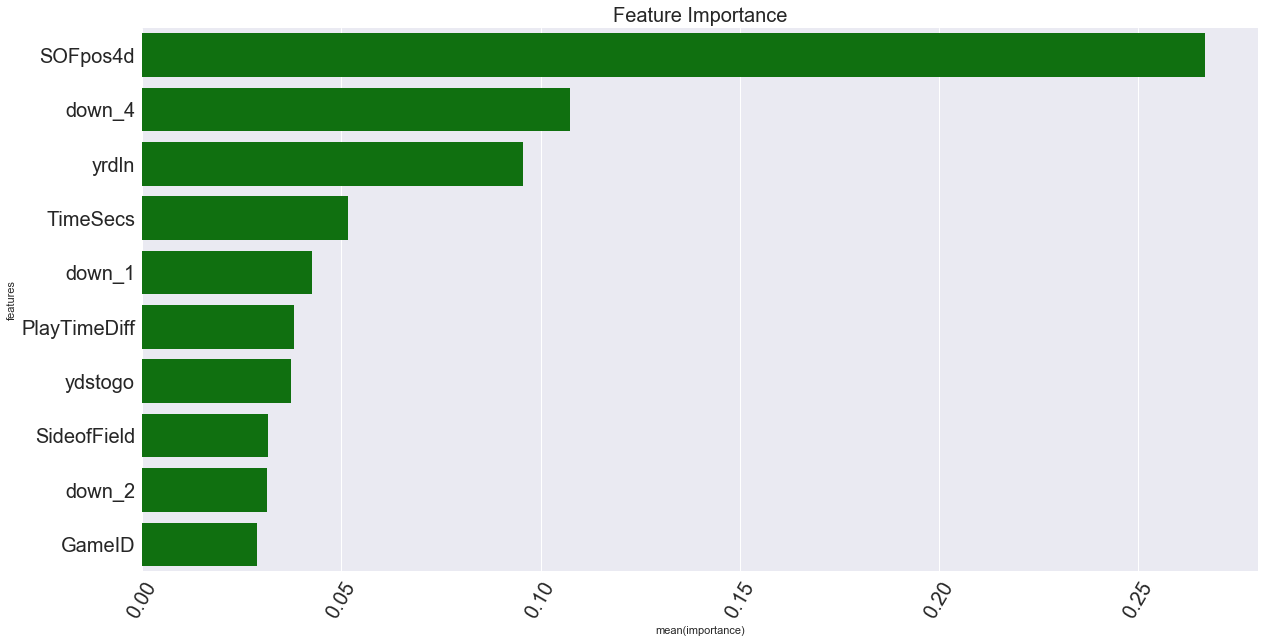

                      features  importance
16                    SOFpos4d    0.266691
20                      down_4    0.107263
4                        yrdln    0.095521
1                     TimeSecs    0.051715
17                      down_1    0.042611
2                 PlayTimeDiff    0.038082
5                      ydstogo    0.037415
3                  SideofField    0.031712
18                      down_2    0.031249
0                       GameID    0.028817
19                      down_3    0.024753
11                   ScoreDiff    0.023063
10                DefTeamScore    0.019871
9                 PosTeamScore    0.018324
12                AbsScoreDiff    0.016681
13        posteam_timeouts_pre    0.012366
6                     GoalToGo    0.011096
14  HomeTimeouts_Remaining_Pre    0.010330
15  AwayTimeouts_Remaining_Pre    0.009228
8                DefensiveTeam    0.008391
7                      posteam    0.007254
30                HomeTeam_DEN    0.001759
32         

In [14]:
plot_importance(clf, makefeatures(df))

The feature I engineered turns out to be very important! Let's look at the confusion matrix to see how each class is being predicted.

Normalized confusion matrix
[[ 0.909  0.061  0.016  0.014]
 [ 0.005  0.711  0.006  0.278]
 [ 0.006  0.003  0.99   0.001]
 [ 0.005  0.35   0.005  0.639]]


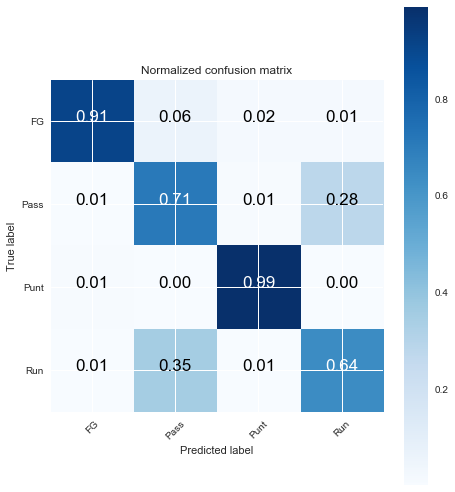

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 17)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

predict = clf.predict(test_x)
class_names =["FG", "Pass", "Punt","Run"]
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, predict)
np.set_printoptions(precision=3)


# Plot normalized confusion matrix
plt.figure(figsize = (7,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.gcf().subplots_adjust(left=0.15)
#plt.savefig("cm.png")

plt.show()

We're doing really well on our kicks and very reasonably with the run/pass game. I'm pleased! Let's train the model on the full data. (Before because of our oversampling we were training on $\frac{n-1}{n}$ of our data.)

In [17]:
clf = RandomForestClassifier(n_estimators=100)
accuracy, clf, test_x, test_y = oversample_clf(clf, df, 1)

Fold #1


Let's export the model so we can use it on the back end of our web app.

In [ ]:
import pickle
pickle.dump( clf, open( "model.p", "wb" ) )

## Conclusion

The random forest model gives the best results with 70% accuracy. Next step is to insert the model into a web app!